In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sqlalchemy import create_engine
import seaborn as sns
from scipy.stats import boxcox
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [142]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()


In [143]:
clean_df = df.copy()
clean_df.alley.unique()
clean_df.alley.fillna('None', inplace=True)
clean_df.lotfrontage.fillna(0, inplace=True)

In [144]:
print(clean_df.masvnrtype.unique())
clean_df.masvnrtype.fillna('None', inplace=True)
clean_df.masvnrarea.fillna(0.0, inplace=True)
print(clean_df.bsmtqual.unique())
clean_df.bsmtqual.fillna('NA', inplace=True)
print(clean_df.bsmtcond.unique())
clean_df.bsmtcond.fillna('NA', inplace=True)
print(clean_df.bsmtexposure.unique())
clean_df.bsmtexposure.fillna('NA', inplace=True)
print(clean_df.bsmtfintype1.unique())
clean_df.bsmtfintype1.fillna('NA', inplace=True)
print(clean_df.bsmtfintype2.unique())
clean_df.bsmtfintype2.fillna('NA', inplace=True)
print(clean_df.bsmtexposure.unique())
clean_df.bsmtexposure.fillna('NA', inplace=True)
print(clean_df.electrical.unique())
for electrical in clean_df.electrical.unique():
    print(electrical, len(clean_df[clean_df.electrical == electrical]))
clean_df.electrical.fillna('SBrkr', inplace=True)
print(clean_df.fireplacequ.unique())
clean_df.fireplacequ.fillna('NA', inplace=True)
print(clean_df.garagetype.unique())
clean_df.garagetype.fillna('NA', inplace=True)
clean_df.garageyrblt.fillna('NA', inplace=True)
clean_df.garagefinish.fillna('NA', inplace=True)
clean_df.garagequal.fillna('NA', inplace=True)
clean_df.garagecond.fillna('NA', inplace=True)
print(clean_df.poolqc.unique())
clean_df.poolqc.fillna('NA', inplace=True)
print(clean_df.fence.unique())
clean_df.fence.fillna('NA', inplace=True)
print(clean_df.miscfeature.unique())
clean_df.miscfeature.fillna('NA', inplace=True)
clean_df.info()

['BrkFace' 'None' 'Stone' 'BrkCmn' None]
['Gd' 'TA' 'Ex' None 'Fa']
['TA' 'Gd' None 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' None]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' None 'LwQ']
['Unf' 'BLQ' None 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' 'NA']
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' None]
SBrkr 1334
FuseF 27
FuseA 94
FuseP 3
Mix 1
None 0
[None 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' None 'Basment' '2Types']
[None 'Ex' 'Fa' 'Gd']
[None 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[None 'Shed' 'Gar2' 'Othr' 'TenC']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1460 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null ob

In [145]:
feature_df = clean_df[['lotarea', 'overallqual']].copy()
x = pd.get_dummies(clean_df.bldgtype, drop_first=True).copy()
for i in range(len(clean_df.bldgtype.unique()) - 1):
    feature_df['bldgtype' + clean_df.bldgtype.unique()[i + 1]] = x.iloc[:,i]
x = pd.get_dummies(clean_df.housestyle, drop_first=True).copy()
for i in range(len(clean_df.housestyle.unique()) - 1):
    feature_df['housestyle' + clean_df.housestyle.unique()[i + 1]] = x.iloc[:,i]
x = pd.get_dummies(clean_df.electrical, drop_first=True).copy()
for i in range(len(clean_df.electrical.unique()) - 1):
    feature_df['electrical' + clean_df.electrical.unique()[i + 1]] = x.iloc[:,i]

In [146]:
keywords = ['garagecond', 'garagequal', 'kitchenqual', 'bsmtcond', 'bsmtqual', 'extercond', 'exterqual' ]
for word in keywords:
    nums = []
    for row in clean_df[word]:
        if row == 'Fa':
            nums.append(1)
        elif row == 'TA':
            nums.append(2)
        elif row == 'Gd':
            nums.append(3)
        elif row == 'Ex':
            nums.append(4)
        else:
            nums.append(0)
    feature_df[word] = nums

In [147]:
from scipy.stats.mstats import winsorize
feature_df['logsaleprice'] = winsorize(np.log(clean_df.saleprice), (0.01, 0.02))

In [148]:
import statsmodels.api as sm

Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     217.3
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:31:40   Log-Likelihood:                 451.04
No. Observations:                1460   AIC:                            -852.1
Df Residuals:                    1435   BIC:                            -719.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3396      0.044    235.743      0.000      10.254      10.426
lotarea            5.11e-06   4.92e-07     10.388      0.000    4.14e-06    6.07e-06
overallqual          0.1309      0.006     22.166      0.000       0.119       0.142
bldgtype2fmCon       0.0120      0.034      0.352      0.725      -0.055       0.079
bldgtypeDuplex       0.0877      0.027      3.263      0.001       0.035       0.140
bldgtypeTwnhsE      -0.2484      0.029     -8.629      0.000      -0.305      -0.192
bldgtypeTwnhs       -0.1394      0.019     -7.530      0.000      -0.176      -0.103
housestyle1Story    -0.1527      0.051     -3.006      0.003      -0.252      -0.053
housestyle1.5Fin     0.0216      0.016      1.313      0.189      -0.011       0.054
housestyle1.5Unf     0.1798      0.065      2.750      0.006       0.052       0.308
housestyleSFoyer    -0.0456      0.057     -0.801      0.423      -0.157       0.066
housestyleSLvl       0.0652      0.018      3.650      0.000       0.030       0.100
housestyle2.5Unf    -0.0572      0.034     -1.659      0.097      -0.125       0.010
housestyle2.5Fin     0.0376      0.027      1.392      0.164      -0.015       0.090
electricalFuseF     -0.0167      0.040     -0.421      0.674      -0.094       0.061
electricalFuseA     -0.0205      0.107     -0.192      0.848      -0.230       0.189
electricalFuseP     -0.3362      0.182     -1.842      0.066      -0.694       0.022
electricalMix        0.0627      0.020      3.111      0.002       0.023       0.102
garagecond           0.0125      0.024      0.524      0.600      -0.034       0.059
garagequal           0.0729      0.023      3.104      0.002       0.027       0.119
kitchenqual          0.0845      0.011      7.769      0.000       0.063       0.106
bsmtcond             0.0007      0.014      0.053      0.958      -0.026       0.027
bsmtqual             0.0855      0.010      8.698      0.000       0.066       0.105
extercond            0.0135      0.014      0.957      0.339      -0.014       0.041
exterqual            0.0595      0.014      4.305      0.000       0.032       0.087
==============================================================================
Omnibus:                      157.452   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.954
Skew:                          -0.494   Prob(JB):                    9.40e-123
Kurtosis:                       5.875   Cond. No.                     5.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+05. This might indicate that there are
strong multicollinearity or other numerical pr

In [149]:
# The following were not statistically significant: bsmtcond, extercond, garagecond. There were others as well but since they were dummy variables
# for categorical variables with more than 2 options, I will keep them for now. I should combine the variables
# into smaller categories.
feature_df.drop(['bsmtcond', 'extercond', 'garagecond'], axis=1, inplace=True)

In [150]:
import statsmodels.api as sm

Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     248.6
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:31:40   Log-Likelihood:                 450.38
No. Observations:                1460   AIC:                            -856.8
Df Residuals:                    1438   BIC:                            -740.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3690      0.031    331.842      0.000      10.308      10.430
lotarea           5.112e-06   4.92e-07     10.401      0.000    4.15e-06    6.08e-06
overallqual          0.1310      0.006     22.201      0.000       0.119       0.143
bldgtype2fmCon       0.0076      0.034      0.224      0.823      -0.059       0.074
bldgtypeDuplex       0.0860      0.027      3.225      0.001       0.034       0.138
bldgtypeTwnhsE      -0.2490      0.029     -8.655      0.000      -0.305      -0.193
bldgtypeTwnhs       -0.1404      0.018     -7.604      0.000      -0.177      -0.104
housestyle1Story    -0.1546      0.051     -3.059      0.002      -0.254      -0.055
housestyle1.5Fin     0.0209      0.016      1.274      0.203      -0.011       0.053
housestyle1.5Unf     0.1782      0.065      2.733      0.006       0.050       0.306
housestyleSFoyer    -0.0450      0.057     -0.796      0.426      -0.156       0.066
housestyleSLvl       0.0641      0.018      3.598      0.000       0.029       0.099
housestyle2.5Unf    -0.0553      0.034     -1.608      0.108      -0.123       0.012
housestyle2.5Fin     0.0372      0.027      1.379      0.168      -0.016       0.090
electricalFuseF     -0.0186      0.039     -0.471      0.638      -0.096       0.059
electricalFuseA     -0.0234      0.107     -0.218      0.827      -0.233       0.186
electricalFuseP     -0.3518      0.181     -1.942      0.052      -0.707       0.004
electricalMix        0.0652      0.020      3.259      0.001       0.026       0.104
garagequal           0.0847      0.010      8.535      0.000       0.065       0.104
kitchenqual          0.0850      0.011      7.850      0.000       0.064       0.106
bsmtqual             0.0851      0.009      9.799      0.000       0.068       0.102
exterqual            0.0592      0.014      4.312      0.000       0.032       0.086
==============================================================================
Omnibus:                      158.239   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.925
Skew:                          -0.493   Prob(JB):                    1.06e-124
Kurtosis:                       5.900   Cond. No.                     5.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
# R^2 is 0.784, adjusted is 0.781, F-stat is 248.6, AIC is -856.8, BIC is -740.5
# I think my model is pretty nifty. But I'm sure it can be improved...Let me try to fix my dummy variables first.

In [152]:
feature_df.head()

,lotarea,overallqual,bldgtype2fmCon,bldgtypeDuplex,bldgtypeTwnhsE,bldgtypeTwnhs,housestyle1Story,housestyle1.5Fin,housestyle1.5Unf,housestyleSFoyer,...,housestyle2.5Fin,electricalFuseF,electricalFuseA,electricalFuseP,electricalMix,garagequal,kitchenqual,bsmtqual,exterqual,logsaleprice
0,8450,7,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,3,3,3,12.247694
1,9600,6,0,0,0,0,0,1,0,0,...,0,0,0,0,1,2,2,3,2,12.109011
2,11250,7,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,3,3,3,12.317167
3,9550,7,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,3,2,2,11.849398
4,14260,8,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,3,3,3,12.429216


In [153]:
for i in df.bldgtype.unique():
    print(i, len(clean_df[clean_df.bldgtype == i]))
# 2fmCon is not significant. I'm going to combine it with duplex since it's a very similar type of structure.

1Fam 1220
2fmCon 31
Duplex 52
TwnhsE 114
Twnhs 43


In [154]:
feature_df.drop(['bldgtype2fmCon'], axis=1, inplace=True)
bldgtype_list = []
for i in df.bldgtype:
    if i == '2fmCon':
        bldgtype_list.append('Duplex')
    else:
        bldgtype_list.append(i)
clean_df['bldgtype'] = bldgtype_list
x = pd.get_dummies(clean_df.bldgtype, drop_first=True).copy()
for i in range(len(clean_df.bldgtype.unique()) - 1):
    feature_df['bldgtype' + clean_df.bldgtype.unique()[i + 1]] = x.iloc[:,i]

In [155]:
feature_df.head()

,lotarea,overallqual,bldgtypeDuplex,bldgtypeTwnhsE,bldgtypeTwnhs,housestyle1Story,housestyle1.5Fin,housestyle1.5Unf,housestyleSFoyer,housestyleSLvl,...,housestyle2.5Fin,electricalFuseF,electricalFuseA,electricalFuseP,electricalMix,garagequal,kitchenqual,bsmtqual,exterqual,logsaleprice
0,8450,7,0,0,0,0,0,0,0,1,...,0,0,0,0,1,2,3,3,3,12.247694
1,9600,6,0,0,0,0,1,0,0,0,...,0,0,0,0,1,2,2,3,2,12.109011
2,11250,7,0,0,0,0,0,0,0,1,...,0,0,0,0,1,2,3,3,3,12.317167
3,9550,7,0,0,0,0,0,0,0,1,...,0,0,0,0,1,2,3,2,2,11.849398
4,14260,8,0,0,0,0,0,0,0,1,...,0,0,0,0,1,2,3,3,3,12.429216


In [156]:
Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     260.4
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:31:40   Log-Likelihood:                 448.59
No. Observations:                1460   AIC:                            -855.2
Df Residuals:                    1439   BIC:                            -744.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3655      0.031    332.036      0.000      10.304      10.427
lotarea           5.045e-06   4.91e-07     10.282      0.000    4.08e-06    6.01e-06
overallqual          0.1314      0.006     22.267      0.000       0.120       0.143
bldgtypeDuplex       0.0564      0.022      2.620      0.009       0.014       0.099
bldgtypeTwnhsE      -0.2497      0.029     -8.672      0.000      -0.306      -0.193
bldgtypeTwnhs       -0.1414      0.018     -7.654      0.000      -0.178      -0.105
housestyle1Story    -0.1571      0.051     -3.107      0.002      -0.256      -0.058
housestyle1.5Fin     0.0237      0.016      1.443      0.149      -0.008       0.056
housestyle1.5Unf     0.1739      0.065      2.667      0.008       0.046       0.302
housestyleSFoyer    -0.0527      0.056     -0.934      0.350      -0.163       0.058
housestyleSLvl       0.0653      0.018      3.668      0.000       0.030       0.100
housestyle2.5Unf    -0.0455      0.034     -1.336      0.182      -0.112       0.021
housestyle2.5Fin     0.0388      0.027      1.439      0.150      -0.014       0.092
electricalFuseF     -0.0146      0.039     -0.369      0.712      -0.092       0.063
electricalFuseA     -0.0309      0.107     -0.289      0.773      -0.241       0.179
electricalFuseP     -0.3524      0.181     -1.944      0.052      -0.708       0.003
electricalMix        0.0658      0.020      3.284      0.001       0.026       0.105
garagequal           0.0852      0.010      8.575      0.000       0.066       0.105
kitchenqual          0.0849      0.011      7.828      0.000       0.064       0.106
bsmtqual             0.0840      0.009      9.685      0.000       0.067       0.101
exterqual            0.0599      0.014      4.360      0.000       0.033       0.087
==============================================================================
Omnibus:                      158.497   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              563.231
Skew:                          -0.499   Prob(JB):                    4.97e-123
Kurtosis:                       5.875   Cond. No.                     5.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
# R^2 is 0.784, adjusted is 0.781, F-stat is 260.4, AIC is -855.2, BIC is -744.2
# BIC got smaller, but AIC went up. Both very slightly. F-statistic went up. I think overall this is very
# slightly better. Lets try doing it on other dummies.

In [158]:
for i in clean_df.housestyle.unique():
    print(i, len(clean_df[clean_df.housestyle == i]))
# Let's combine both 1.5 story, and then combine split foyer with split level, and put 2.5 stories into 2 story.

2Story 445
1Story 726
1.5Fin 154
1.5Unf 14
SFoyer 37
SLvl 65
2.5Unf 11
2.5Fin 8


In [159]:
len(feature_df)

1460

In [160]:
feature_df.drop(['housestyle1.5Unf', 'housestyleSFoyer', 'housestyle2.5Unf', 'housestyle2.5Fin'], axis=1, inplace=True)
housestyle_list = []
for i in clean_df.housestyle:
    if i == '1.5Unf':
        housestyle_list.append('1.5Fin')
    elif i == 'SFoyer':
        housestyle_list.append('SLvl')
    elif i == '2.5Unf':
        housestyle_list.append('2Story')
    elif i == '2.5Fin':
        housestyle_list.append('2Story')
    else:
        housestyle_list.append(i)
clean_df['housestyle'] = housestyle_list
x = pd.get_dummies(clean_df.housestyle, drop_first=True).copy()
for i in range(len(clean_df.housestyle.unique()) - 1):
    feature_df['housestyle' + clean_df.housestyle.unique()[i + 1]] = x.iloc[:,i]

In [161]:
Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     320.1
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:31:40   Log-Likelihood:                 437.41
No. Observations:                1460   AIC:                            -840.8
Df Residuals:                    1443   BIC:                            -751.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3474      0.031    334.107      0.000      10.287      10.408
lotarea           5.148e-06   4.93e-07     10.437      0.000    4.18e-06    6.12e-06
overallqual          0.1310      0.006     22.282      0.000       0.119       0.143
bldgtypeDuplex       0.0506      0.022      2.352      0.019       0.008       0.093
bldgtypeTwnhsE      -0.2529      0.029     -8.756      0.000      -0.310      -0.196
bldgtypeTwnhs       -0.1426      0.019     -7.672      0.000      -0.179      -0.106
housestyle1Story     0.0357      0.016      2.228      0.026       0.004       0.067
housestyle1.5Fin     0.0767      0.017      4.427      0.000       0.043       0.111
housestyleSLvl       0.0207      0.023      0.886      0.376      -0.025       0.067
electricalFuseF     -0.0271      0.040     -0.687      0.492      -0.105       0.050
electricalFuseA     -0.0229      0.108     -0.213      0.832      -0.234       0.188
electricalFuseP     -0.3459      0.182     -1.896      0.058      -0.704       0.012
electricalMix        0.0682      0.020      3.387      0.001       0.029       0.108
garagequal           0.0887      0.010      8.917      0.000       0.069       0.108
kitchenqual          0.0846      0.011      7.772      0.000       0.063       0.106
bsmtqual             0.0828      0.009      9.542      0.000       0.066       0.100
exterqual            0.0610      0.014      4.417      0.000       0.034       0.088
==============================================================================
Omnibus:                      148.312   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.492
Skew:                          -0.459   Prob(JB):                    1.05e-115
Kurtosis:                       5.804   Cond. No.                     5.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
# R^2 is 0.780, adjusted is 0.778, F-stat is 320.1, AIC is -840.8, BIC is -751.
# R^2 and AIC got worse, F-stat and BIC improved. I think overall this is worse somehow...
# Combining the two split level types doesn't feel right. Let me try the last dummy fix

In [163]:
for i in clean_df.electrical.unique():
    print(i, len(clean_df[clean_df.electrical == i]))

SBrkr 1335
FuseF 27
FuseA 94
FuseP 3
Mix 1


In [164]:
feature_df.drop(['electricalFuseF', 'electricalFuseA', 'electricalFuseP', 'electricalMix'], axis=1, inplace=True)
electrical_list = []
for i in clean_df.electrical:
    if i == 'SBrkr':
        electrical_list.append(1)
    else:
        electrical_list.append(0)
feature_df['electricalisSBrkr'] = electrical_list

In [165]:
list(feature_df.columns)
columnsTitles = ['lotarea',
 'overallqual',
 'bldgtypeDuplex',
 'bldgtypeTwnhsE',
 'bldgtypeTwnhs',
 'housestyle1Story',
 'housestyle1.5Fin',
 'housestyleSLvl',
 'garagequal',
 'kitchenqual',
 'bsmtqual',
 'exterqual',
 'electricalisSBrkr',
 'logsaleprice',]
feature_df = feature_df.reindex(columns=columnsTitles)

In [166]:
Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     393.4
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:31:40   Log-Likelihood:                 435.41
No. Observations:                1460   AIC:                            -842.8
Df Residuals:                    1446   BIC:                            -768.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.3365      0.029    352.940      0.000      10.279      10.394
lotarea            5.143e-06   4.93e-07     10.424      0.000    4.18e-06    6.11e-06
overallqual           0.1306      0.006     22.263      0.000       0.119       0.142
bldgtypeDuplex        0.0512      0.021      2.390      0.017       0.009       0.093
bldgtypeTwnhsE       -0.2528      0.029     -8.752      0.000      -0.309      -0.196
bldgtypeTwnhs        -0.1429      0.019     -7.688      0.000      -0.179      -0.106
housestyle1Story      0.0348      0.016      2.182      0.029       0.004       0.066
housestyle1.5Fin      0.0761      0.017      4.402      0.000       0.042       0.110
housestyleSLvl        0.0196      0.023      0.839      0.402      -0.026       0.065
garagequal            0.0907      0.010      9.179      0.000       0.071       0.110
kitchenqual           0.0849      0.011      7.813      0.000       0.064       0.106
bsmtqual              0.0839      0.009      9.716      0.000       0.067       0.101
exterqual             0.0604      0.014      4.383      0.000       0.033       0.087
electricalisSBrkr     0.0767      0.018      4.244      0.000       0.041       0.112
==============================================================================
Omnibus:                      145.872   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              519.453
Skew:                          -0.451   Prob(JB):                    1.59e-113
Kurtosis:                       5.780   Cond. No.                     1.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
# R^2 is 0.780, adjusted is 0.778, F-stat is 393.4, AIC is -842.8, BIC is -768.8.
# This is better than our last one in every way, but I'm still drawn to my first edit with R^2 = .784
# I'll call a tie between that one and this model.

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

Y = feature_df['logsaleprice']
X = feature_df.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 21)

X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     320.8
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:40:05   Log-Likelihood:                 358.17
No. Observations:                1168   AIC:                            -688.3
Df Residuals:                    1154   BIC:                            -617.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.3330      0.033    315.730      0.000      10.269      10.397
lotarea            5.204e-06    5.6e-07      9.297      0.000    4.11e-06     6.3e-06
overallqual           0.1288      0.007     19.810      0.000       0.116       0.142
bldgtypeDuplex        0.0647      0.023      2.824      0.005       0.020       0.110
bldgtypeTwnhsE       -0.2591      0.032     -8.137      0.000      -0.322      -0.197
bldgtypeTwnhs        -0.1426      0.021     -6.768      0.000      -0.184      -0.101
housestyle1Story      0.0205      0.018      1.158      0.247      -0.014       0.055
housestyle1.5Fin      0.0673      0.019      3.541      0.000       0.030       0.105
housestyleSLvl        0.0195      0.026      0.748      0.455      -0.032       0.071
garagequal            0.0950      0.011      8.592      0.000       0.073       0.117
kitchenqual           0.0849      0.012      6.840      0.000       0.061       0.109
bsmtqual              0.0880      0.010      9.222      0.000       0.069       0.107
exterqual             0.0651      0.015      4.246      0.000       0.035       0.095
electricalisSBrkr     0.0681      0.020      3.420      0.001       0.029       0.107
==============================================================================
Omnibus:                      116.488   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.333
Skew:                          -0.430   Prob(JB):                     9.74e-94
Kurtosis:                       5.839   Cond. No.                     1.01e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

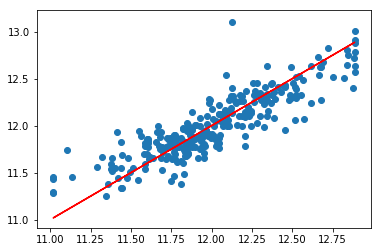

Mean absolute error of the prediction is: 0.13965262185091615
Mean squared error of the prediction is: 0.034661256576592483
Root mean squared error of the prediction is: 0.1861753382609858
Mean absolute percentage error of the prediction is: 1.1671604667413324


In [172]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [ ]:
# These are all very low, which is good. My model's target variable is a log transformation so these are not
# actually THAT crazy low.